<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>

Светлана, доброго дня! рад приветствовать тебя) <br />
<br />
Меня зовут Николай Шавлюго. <br />И на этом этапе твоего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='orange'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако есть на что обратить внимание в плане применения техник, или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Моей целью является не "уличить" в не знании, а просто высказать сверху твоих знаний - свой опыт, что бы ты мог использовать его для своего дальнейшего успеха) И очень здорово будет, если тебе удастся задавать вопросы, да и вообще - всячески доставать меня, если я по каким-то причинам не приму проект:) При этом, из своего опыта скажу, хорошо и важно, когда переписка ревьюера и студента - сохраняется на следующие проекты и даже на будущую практическую деятельность.<br>
<br> Я сразу же начал общаться на ты:) но если это не очень удобно, то дай знать)) <BR> В ПУТЬ!<br>

<mark>Привет! Все мои новые комментарии будут выделены так

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.


# 1. Загрузите данные и выполните их ресемплирование по одному часу


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

from datetime import date
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Информация о данных:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, в хронологическом ли порядке расположены даты и время.

In [4]:
print(df.index.is_monotonic)

True


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Ресемплинг ряда с длиной интервала 1 час. Агрегированное значение ряда – сумма.

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>ОК, данные на базе)

## Вывод

Загруженный датасет не нуждается в предобработке, поэтому кроме вывода информации было проведено ресемлирование по одному часу и проверена монотонность данных. Дальнейший анализ будет в следующей главе.


# 2. Анализ данных


Функция для удобства отрисовки графика

In [7]:
def plot(pl, name):
    plt.figure(figsize=(20,10))
    plt.title(name, fontsize=16)
    plt.plot(pl)
    plt.show()

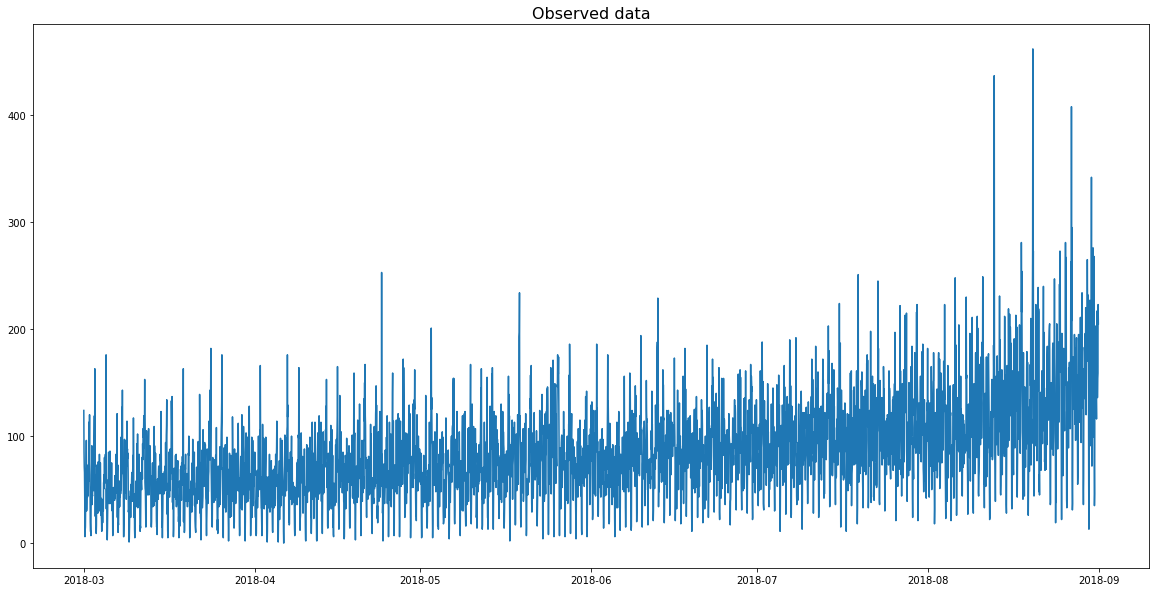

In [8]:
warnings.filterwarnings('ignore')

plot(df, 'Observed data')

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Такая команда (можно поместить в самое начало тетрадки) иногда может помочь не выводить предупреждения)<br>
import warnings<br>
warnings.filterwarnings('ignore')<br>

Скользящее среднее и стандартное отклонение

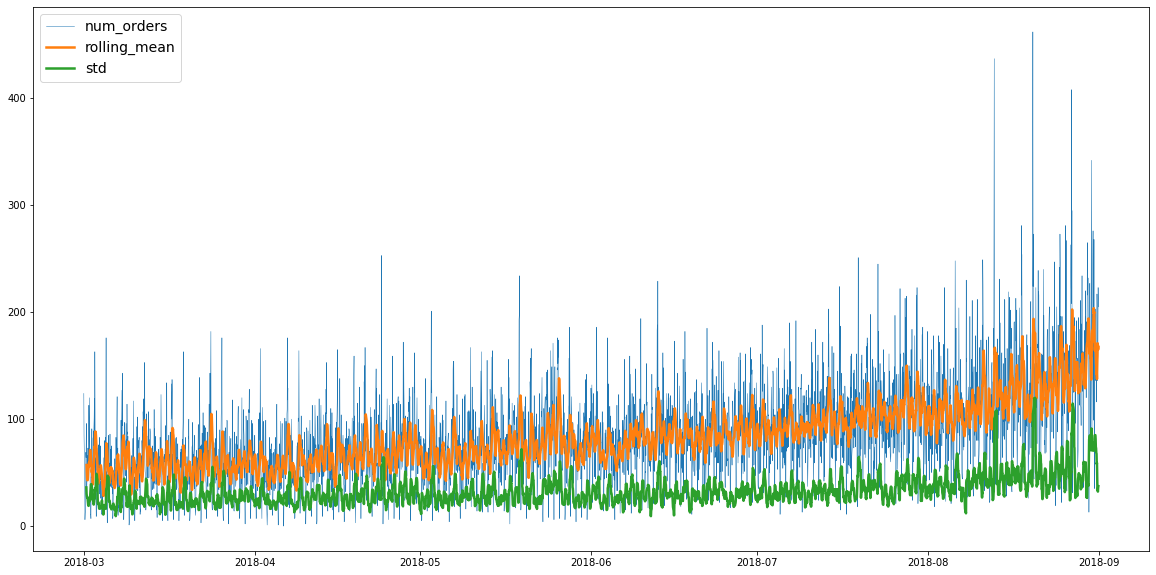

In [9]:
plt.figure(figsize=(20,10))
#plt.title(name, fontsize=16)
plt.plot(df, linewidth=0.5, label='num_orders')
plt.plot(df['num_orders'].shift().rolling(12).mean(), linewidth=2.5, label='rolling_mean')
plt.plot(df['num_orders'].rolling(12).std(), linewidth=2.5,label='std')
plt.legend(loc='upper left', fontsize=14)
plt.show()

- Среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный, в случае стационарности они бы не менялись

- Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу, но на это предстоит посмотреть и после декомпозиции


Разложение временного ряда на тренд, сезонность и остаток

In [10]:
decomposed = seasonal_decompose(df)

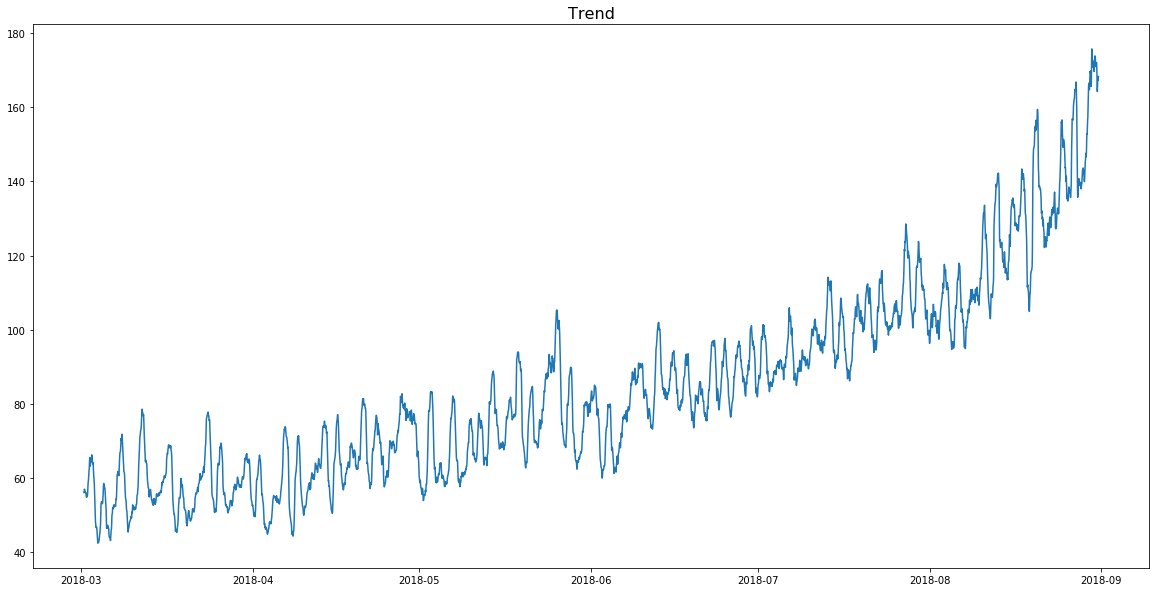

In [11]:
plot(decomposed.trend, 'Trend')

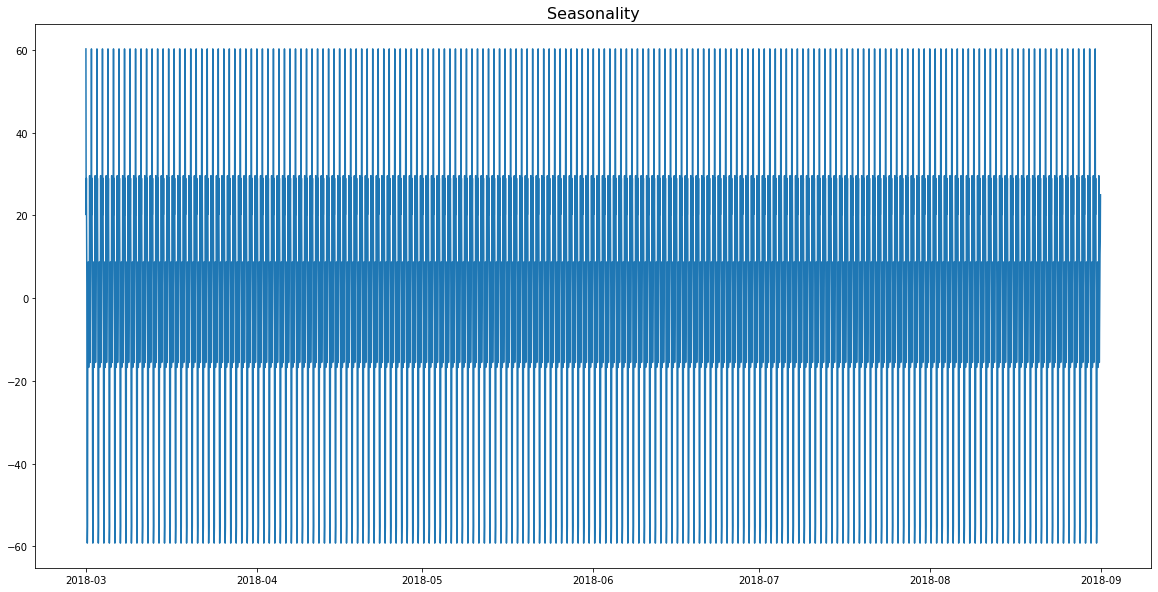

In [12]:
plot(decomposed.seasonal, 'Seasonality')

Это была сезонность всего датасета при ресемплинге 1 час. Посмотрим сезонность за несколько дней, может что-то прояснится.

Сезонность за двое суток

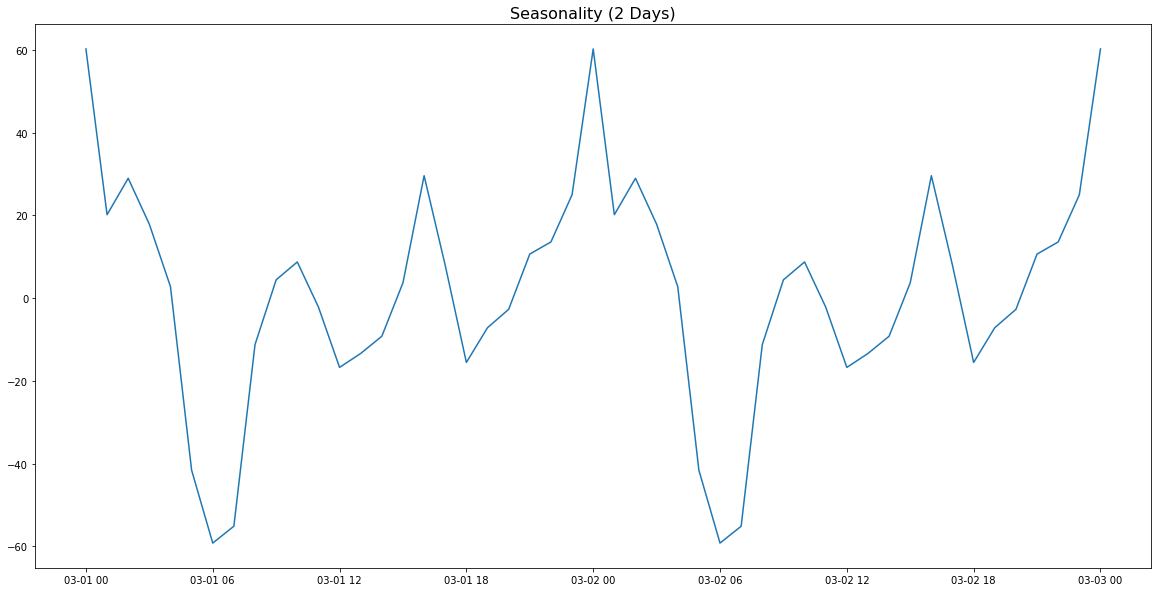

In [13]:
plot(decomposed.seasonal.head(49), 'Seasonality (2 Days)')

Очевиден рост количества заказов после полуночи, с утра, часов в 9, когда все собираются на работу и ближе к вечеру, часов в 18, когда работа заканчивается

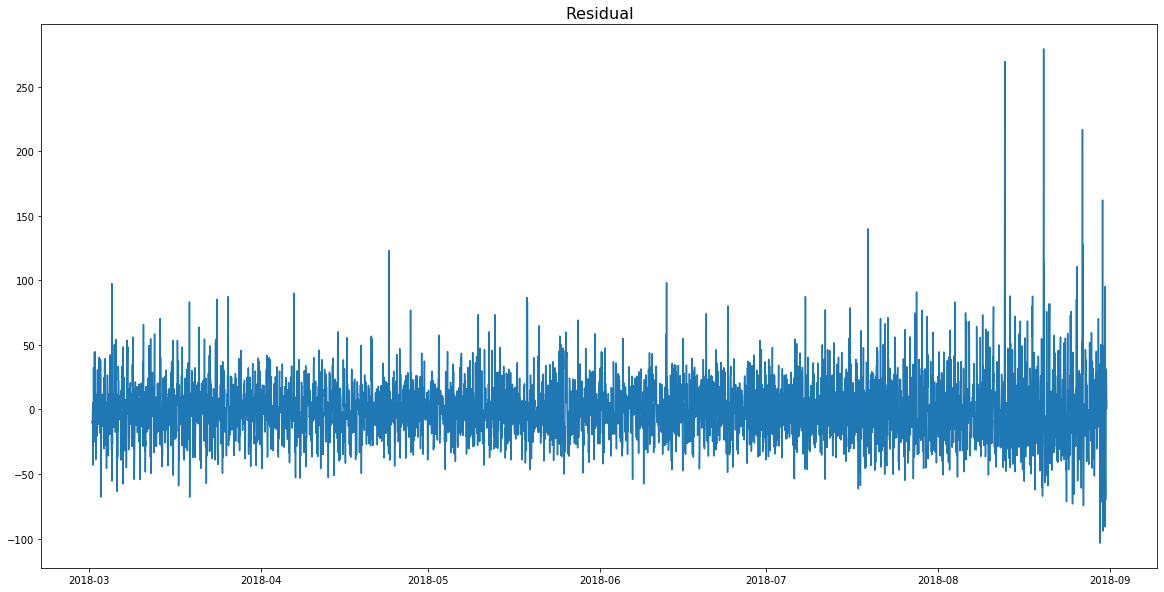

In [14]:
plot(decomposed.resid, 'Residual')

## Вывод

Временной ряд не является стационарным. В данных присутствует восходящий тренд и дневная сезонность. 

Среди дня самым популярным временем становятся промежуток около полуночи , когда транспорт перестает ходить, а также очевиден рост в часы пик - 9 утра и 18 часов – время, когда люди едут на работу/возвращаются с неё.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Исследование - понятно.<font color='green'><br> 
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - очень нужный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это очень помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1) дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2) внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером <br>
3) месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.

<mark> В данной задаче понятно про горизонт прогноза, что он равен одному часу. А вообще, получается, горизонт прогноза равен величине по которой делаем ресемплинг?

# 3. Обучение разных моделей с различными гиперпараметрами


Добавим признак `is_weekend`, который отображает, текущая дата выходной или нет. Праздничные дни за 2018 год тоже выходные. 

Данные скачаны с https://data.gov.ru/opendata/7708660670-proizvcalendar, но для удобства откроем их с гитхаба.

In [15]:
url = 'https://raw.githubusercontent.com/svetamw/Time_Series/main/data.csv'
df_calendar = pd.read_csv(url,index_col=0)
df_calendar.head()

,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Всего рабочих дней,Всего праздничных и выходных дней,Количество рабочих часов при 40-часовой рабочей неделе,Количество рабочих часов при 36-часовой рабочей неделе,Количество рабочих часов при 24-часовой рабочей неделе
Год/Месяц,,,,,,,,,,,,,,,,,
1999,"1,2,3,4,6*,7,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25,30*","1,2,3,4,8,9,10,15,16,22,23,29,30","5,6,11*,12,13,14,19,20,26,27","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","2,3,9,10,16,17,23,24,30,31","6,7,8,13,14,20,21,27,28","4,5,11,12,13,18,19,25,26,31*",251,114,2004,1807.2,1204.8
2000,"1,2,3,4,6*,7,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","4,5,7*,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","1,2,6,7,8*,9,13,14,20,21,27,28","3,4,10,11,12,17,18,24,25","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,7,11,12,18,19,25,26","2,3,9,10,11*,12,16,17,23,24,30,31",250,116,1995,1800.0,1200.0
2001,"1,2,6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25","3,4,7*,8,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29,30*","1,2,5,6,8*,9,12,13,19,20,26,27","2,3,9,10,11*,12,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,6*,7,10,11,17,18,24,25","1,2,8,9,12,15,16,22,23,29,30",251,114,2001,1807.2,1204.8
2002,"1,2,5,6,7,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24,25","2,3,7*,8,9,10,16,17,23,24,30,31","6,7,13,14,20,21,28,30*","1,2,3,4,5,8*,9,10,11,12,19,25,26","1,2,8,9,11*,12,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,6*,7,8,9,16,17,23,24,30","1,7,8,11*,12,13,14,21,22,28,29,31*",250,115,1992,1792.0,1192.0
2003,"1,2,3,5*,6,7,11,12,18,19,25,26","1,2,8,9,15,16,22,23,24","1,2,7*,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,26,27,30*","1,2,3,4,8*,9,10,11,17,18,24,25,31","1,7,8,11*,12,13,14,15,22,28,29","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","4,5,11,12,18,19,25,26","1,2,6*,7,8,9,15,16,22,23,29,30","6,7,11*,12,13,14,20,21,27,28,31*",250,115,1992,1792.0,1192.0


In [16]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 1999 to 2025
Data columns (total 17 columns):
Январь                                                    27 non-null object
Февраль                                                   27 non-null object
Март                                                      27 non-null object
Апрель                                                    27 non-null object
Май                                                       27 non-null object
Июнь                                                      27 non-null object
Июль                                                      27 non-null object
Август                                                    27 non-null object
Сентябрь                                                  27 non-null object
Октябрь                                                   27 non-null object
Ноябрь                                                    27 non-null object
Декабрь                                      

Выберем только 2018 год, а в `cols` только те месяцы, которые есть в основном датасете

In [17]:
df1 = df_calendar[19:20]
cols = [ 'Март', 'Апрель', 'Май',
       'Июнь', 'Июль', 'Август']

Из-за своеобразного формата данных необходимо выполнить небольшую предобработку и привести к виду `Y-m-d`.

Эти преобразованные данные в нужном формате будет хранить список `l`. 

In [18]:
l = []
for col in cols:
    m = df1[col].tolist()[0].replace(',', ' ').replace('*', '').split()
    for day in m:
        l.append(date(2018,  cols.index(col) + 3, int(day)))

In [19]:
l[:5]

[datetime.date(2018, 3, 3),
 datetime.date(2018, 3, 4),
 datetime.date(2018, 3, 7),
 datetime.date(2018, 3, 8),
 datetime.date(2018, 3, 9)]

Создание признака `is_weekend`. Дата из `df` находится и в списке `l` - присваиваем 1, иначе 0

In [20]:
df['is_weekend'] = 0
for i in range(len(df)):
    if date(df.index[i].year, df.index[i].month, df.index[i].day) in l:
        df['is_weekend'][i] = 1
    else:
        df['is_weekend'][i] = 0

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Пометить праздники - идея интересная!

Создадим календарные признаки:

- год
- месяц
- день 
- день недели
- час


In [21]:
#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='red'><br>
На мой взгляд: не все факторы подходят, чисто логически. Выскажу свою позицию:<br><br>

1) Фактор год: НЕТ, однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: НЕТ, аналогично году, у нас в истории всего один март, май.... Да и горизоно прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.<br>
3) Фактор день: НЕТ, также не подходит, будет просто последовательность чисел<br>
4) Фактор день недели: ДА, т.к. у нас есть недельная сезонность<br>
5) Фактор час: ДА, т.к. есть часовая (суточная) сезонность.<br>
6) Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда <br>

Как ты думаешь?

<mark>Да, согласна, год просто константа, поэтому не будем делать из него новый признак.

<mark>Как уже сказано выше, сезонность времени года уже заложена в тренде, из месяца тоже не будем делать новый признак.

<mark>Про день то же самое, как и про месяц, не будем добавлять этот признак.

<mark>Добавим признак `lag`

<mark>Добавим признак `rolling`
    
<mark>Единственное, что меня беспокоит в этом – *утечка данных* при использовании **rolling_mean**, ведь мы при его подсчёте используем и текущее значение таргета

Тем не менее добавим 12 лагов и скользящее среднее с размером окна 12.

In [22]:
max_lag = 12
for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

df['rolling_mean'] = df['num_orders'].shift().rolling(12).mean()
df.dropna(inplace=True)

In [23]:
df.head()

,num_orders,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,0,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,57.083333
2018-03-01 13:00:00,32,0,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,49.250000
2018-03-01 14:00:00,48,0,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,44.833333
2018-03-01 15:00:00,66,0,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,42.916667
2018-03-01 16:00:00,43,0,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,42.916667


Поделим выборку на train и test

In [24]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Создадим функцию, которая в дальнейшем упростит fit / predict и подсчёт метрики.

Напомним, что RMSE считается следующим образом:

$$RMSE = \sqrt{\frac{\sum_{i}^{N} (pred_i - actual_i)^2}{N}}.$$

In [25]:
def fit_predict_evaluate(X_train, X_test, y_train, y_test, model):
    
    start = time.time()  
    model.fit(X_train, y_train)
    training_time = time.time() - start
    
    start = time.time()  
    pred = model.predict(X_test)
    predict_time = time.time() - start
    print('Training time: ', training_time)
    print('Predict time: ', predict_time)
    print()
    
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('RMSE:', round((rmse), 2))
    print('Mean', round(pred.mean(), 2))
    print('Scatter index', round(rmse/pred.mean(), 2))

In [26]:
#ts_cv = TimeSeriesSplit(n_splits=2)

<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='green'><br>Отлично! с 
n_splits такой момент: обычно, задают так, чтобы размер валидационной выборки при проведении кросс-валидации примерно совпадал с размером тестовой выборки. Размер тестовой выборки у нас 10%, а размер валидационной равен 1/(n_splits+1) части от обучающей выборки (см. документацию к TimeSeriesSplit). К примеру, если n_splits=2, то размер валидационной равен 1/3 от обучающей выборки, т.е. 1/3*90%=30% от исходной выборки.<br>
  
Возможно, что n_splits=8, то 1/9*90%=10%  - будет более точное попадание.

<mark>Ок, спасибо за разъяснение, раньше до конца не понимала про то, чему должен быть равен `n_splits`</mark>

In [27]:
ts_cv = TimeSeriesSplit(n_splits=8)

## Random Forest

In [28]:
parameters = {'n_estimators': range(10,101,20),
              'max_depth': range(1,8,3), 
              'min_samples_leaf': range(1,5,2),
              'min_samples_split': range(2,6,2)}

model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(model, parameters, cv=ts_cv, scoring='neg_mean_squared_error')
grid.fit(train_features, train_target)

grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 70}

## LightGBM

In [29]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=42)
gbm_params = {'learning_rate': np.logspace(-3, 0, 5),
              'n_estimators': range(20, 61, 20),
              'num_leaves': range(20, 41, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=ts_cv, scoring='neg_mean_squared_error')
grid_gbm.fit(train_features, train_target);

grid_gbm.best_params_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threa

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You 

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
CPU times: user 1min 1s, sys: 1.9 s, total: 1min 2s
Wall time: 17.5 s


{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 30}

## CatBoost

In [30]:
%%time

cbr = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=42)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),
              'iterations': range(20, 60, 20),
              'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=ts_cv, scoring='neg_mean_squared_error')
grid_cbr.fit(train_features, train_target);

grid_cbr.best_params_

CPU times: user 1min 23s, sys: 5.19 s, total: 1min 29s
Wall time: 31.3 s


{'depth': 7, 'iterations': 40, 'learning_rate': 0.1778279410038923}

## Вывод

 Были добавлены новые признаки:
  `is_weekend`,
 `year`, `month`, `dayofweek`, `hour`
 
Далее данные были поделены на `train` / `test` в соотношении 9/1.

Для удобства в дальнейшей работе была написана функция `fit_predict_evaluate` которая работает в соответствие со своим названием, а так же подсчитывает RMSE и Scatter Index.

Далее с помощью GridSearch были перебраны параметры трёх моделей: Random Forest, CatBoost и LightGBM. К

В следующей части проверим модели с подобранными оптимальными параметрами на тестовой выборке.

# 4. Проверьте данные на тестовой выборке и сделайте выводы.

## Random Forest

In [31]:
model_rf = RandomForestRegressor(max_depth=7,
                              min_samples_leaf=3,
                              min_samples_split=2,
                              n_estimators=30,
                              random_state=42)

In [32]:
%%time
fit_predict_evaluate(train_features, test_features, train_target, test_target, model_rf)

Training time:  0.40247297286987305
Predict time:  0.0025310516357421875

RMSE: 48.58
Mean 115.88
Scatter index 0.42
CPU times: user 395 ms, sys: 5.87 ms, total: 401 ms
Wall time: 406 ms


## LightGBM

In [33]:
model_gbm = LGBMRegressor(learning_rate=0.177,
                          #max_depth=10,
                          n_estimators=20,
                          num_leaves=30)

In [34]:
%%time
fit_predict_evaluate(train_features, test_features, train_target, test_target, model_gbm)

Training time:  0.04153323173522949
Predict time:  0.004803180694580078

RMSE: 45.53
Mean 120.36
Scatter index 0.38
CPU times: user 122 ms, sys: 13.4 ms, total: 135 ms
Wall time: 47.1 ms


## CatBoost

In [35]:
model_cb = CatBoostRegressor(loss_function='RMSE',
                          verbose=0, 
                          depth=7, 
                          iterations=40, 
                          learning_rate=1.)

In [36]:
%%time
fit_predict_evaluate(train_features, test_features, train_target, test_target, model_cb)

Training time:  0.2172091007232666
Predict time:  0.0015616416931152344

RMSE: 46.94
Mean 125.39
Scatter index 0.37
CPU times: user 596 ms, sys: 88.4 ms, total: 684 ms
Wall time: 219 ms


___
График предсказанных значений (лучшей моделью) в сравнении с `test_target`

In [37]:
model_gbm.fit(train_features, train_target)
test_predicted = model_gbm.predict(test_features)

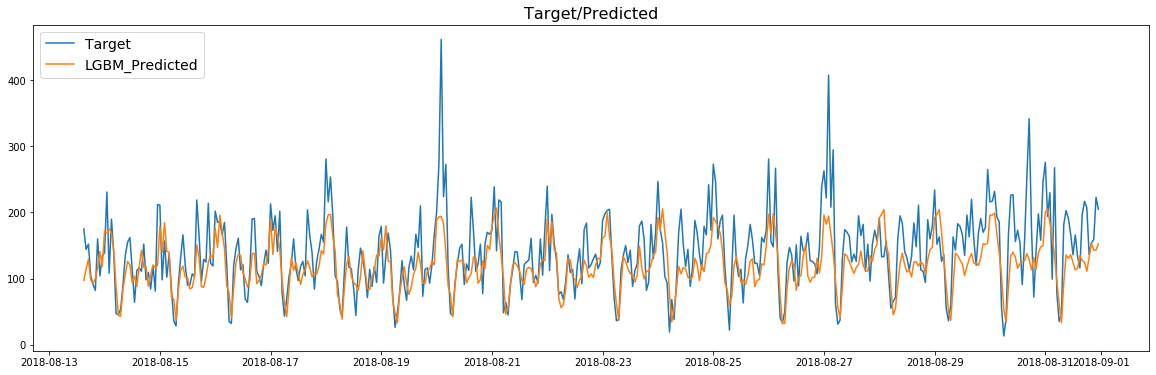

In [38]:
plt.figure(figsize=(20, 6))
plt.plot(test_target, label='Target')
plt.plot(test_target.index, test_predicted, label='LGBM_Predicted')
plt.title('Target/Predicted', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.show()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>отлично!<br>
Глядя на график, а также добавляя отдельный анализ остатков, можно будет хорошо порабоать над улучшением модели..<br> На последнем вот графике видно, что тренд  - плохо отрабатыват в модели... 

<mark> Да, согласна, что на графике видно отсутствие тренда. Думаю, в будущем надо попробовать такие модели как ARIMA/SARIMA и двойное/тройное экспоненциальное сглаживание. Но на данный момент для лучшей модели RMSE < 48 , что в общем-то удовлетворяет критерию сдачи проекта. 

После проверки моделей на тестовой выборке получили следующие данные:</code>


|                  | RMSE          | Time          |
|-----------       | ------------- | ------------- |
|**Random Forest** | 48.58        | 406 ms |
|**LightGBM**      | 45.53        | 47.1 ms |
|**CatBoost**      | 46.94         | 219 ms |

# Вывод

После тестирования моделей на подобранных параметрах лучший результат показал LightGBM (RMSE=45.53). 

На втором месте CatBoost (RMSE = 46.94).

По скорости также выигрывает LightGBM, так что данная модель в этом случае – оптимальный выбор. Также приведен график сравнения предсказанных значений и заранее известных (test target). По графику видно, что модель хорошо схватывает общую форму, но немного не дотягивает на очень высоких значениях. Есть, куда стремиться 🙂


<mark> Очевидно, надо попробовать модели, которые будут учитывать тренд. А ещё лучше было бы получить данные хотя бы за 2 года и выяснить природу этого тренда, а потом действовать по ситуации.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Светлана, с модельной частью справилась хорошо!<br>
Видно, что этот скил уже достаточно сильный у тебя.<br>
Метрика - ОК. Но не понятно, если честно, а хороша ли эта модель в плане предсказания? Для этого лучше построить дополнительно график (чуть ниженаписал об этом).<br>
    
И если сутейно рассуждать, то временные ряды стоят особняком во всём курсе, я бы сказал. Тут чуть иная модельная философия, на мой взгляд. Имменно поэтому позволял себе оставлять большие комментарии, чтобы как-то раскрыть её особенности.<br>
    
Уверен, что сумев понять главную особенность временных рядов - составляющие ряда и их влияние на прогноз продаж, у тебя появится ещё более уверенный скил и по этой теме.<br>
<font color='red'>    
Оставил несколько комментариев в тексте - готов буду ответить на твои вопросы!<br>
<font color='green'>
Спасибо)<BR>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ

<mark> Хорошо, поняла. Теперь хочется почитать не только теорию о временных рядах, но и посмотреть хорошие примеры применения моделей. 

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Хотел бы оставить несколько идей для твоих будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.

<mark>Спасибо за такие подробные комментарии! Теперь предстоит ещё многое осмыслить во временных рядах

In [39]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= 'https://habrastorage.org/files/234/dcd/2fc/234dcd2fca894e80bc4c753e67bf613f.jpg')